In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random

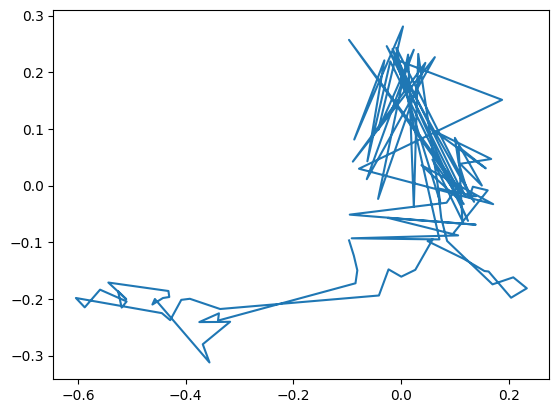

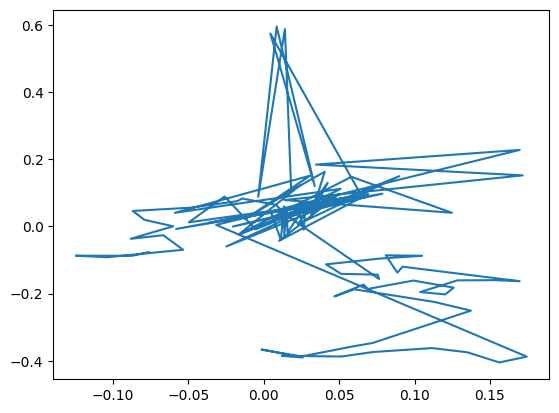

In [12]:
# generate dataset

dataset_size = 1000
n_dim = 3
sample_len = 100

l = [1,1,1,1,1,1,-1]
sample_path_1 = np.ones((sample_len, n_dim))
for i in range(1, sample_len):
    sample_path_1[i] = sample_path_1[i-1] + (np.random.normal(0, 1, n_dim))**l[random.randint(0, 6)]
for i in range(int(sample_len/2), sample_len):
    sample_path_1[i] = (np.abs(sample_path_1[i-1]**2 - sample_path_1[i]**2))**0.5


sample_path_2 = np.zeros((sample_len, n_dim))
for i in range(1, sample_len):
    sample_path_2[i] = sample_path_2[i-1] + (np.random.normal(0, 1, n_dim))**l[random.randint(0, 6)]
for i in range(int(sample_len/2), sample_len):
    sample_path_2[i] = (np.abs(sample_path_2[i-1]**2 - sample_path_2[i]**2))**0.5


#normalize paths
sample_path_1 -= np.average(sample_path_1)
sample_path_2 -= np.average(sample_path_2)
sample_path_1 /= np.max(sample_path_1)-np.min(sample_path_1)+0.001
sample_path_2 /= np.max(sample_path_2)-np.min(sample_path_2) +0.001


plt.plot(sample_path_1[:, 0], sample_path_1[:, 1])
plt.show()
plt.plot(sample_path_2[:, 0], sample_path_2[:, 1])
plt.show()


X1 = np.random.rand(int(dataset_size/2))
X1 = np.array([sample_path_1*i for i in X1])
X1 = np.tensordot(X1, np.array([[0.8, -0.5, 1], [2, 1, 3], [-0.5, -1, 1]]), axes=((2),(0)))
X1 += np.random.rand(X1.shape[0], X1.shape[1], X1.shape[2])

X2 = np.random.rand(int(dataset_size/2))
X2 = np.array([sample_path_2*i for i in X2])
X2 = np.tensordot(X2, np.array([[0.5, -1, 0], [4, 2, 1.2], [0.8, -0.5, 1]]), axes=((2),(0)))
X2 += np.random.rand(X2.shape[0], X2.shape[1], X2.shape[2])

#normalize data
X1 -= np.average(X1)
X2 -= np.average(X2)

X = np.concatenate([X1, X2])
X = np.transpose(X, (0, 2, 1))
Y = np.concatenate([np.zeros(int(dataset_size/2)), np.ones(int(dataset_size/2))])

In [13]:
"""from mne.decoding import CSP

# Create the CSP object
csp = CSP(n_components=2, transform_into='csp_space')

# Fit the CSP on the data
print(X.shape)
print(Y.shape)
csp.fit(X, Y)
        
# Apply the CSP to the data
X_csp = csp.transform(X)

print(X_csp.shape)

print(csp.filters_)
print(csp.patterns_)



covs, sample_weights = csp._compute_covariance_matrices(X, Y)
eigen_vectors, eigen_values = csp._decompose_covs(covs, sample_weights)
ix = csp._order_components(
    covs, sample_weights, eigen_vectors, eigen_values, csp.component_order
    )
print(eigen_vectors)
print(eigen_values)
print(ix)"""

"from mne.decoding import CSP\n\n# Create the CSP object\ncsp = CSP(n_components=2, transform_into='csp_space')\n\n# Fit the CSP on the data\nprint(X.shape)\nprint(Y.shape)\ncsp.fit(X, Y)\n        \n# Apply the CSP to the data\nX_csp = csp.transform(X)\n\nprint(X_csp.shape)\n\nprint(csp.filters_)\nprint(csp.patterns_)\n\n\n\ncovs, sample_weights = csp._compute_covariance_matrices(X, Y)\neigen_vectors, eigen_values = csp._decompose_covs(covs, sample_weights)\nix = csp._order_components(\n    covs, sample_weights, eigen_vectors, eigen_values, csp.component_order\n    )\nprint(eigen_vectors)\nprint(eigen_values)\nprint(ix)"

com scypy

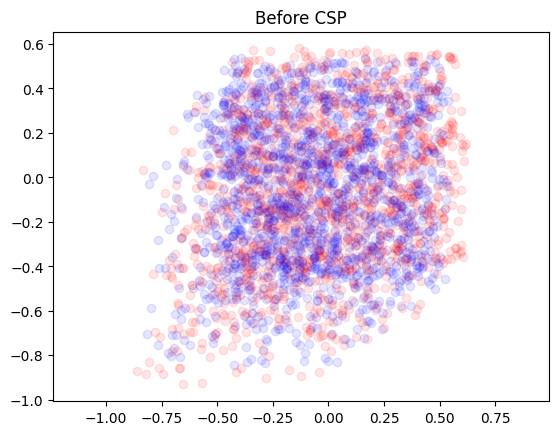

(1000, 2, 100)


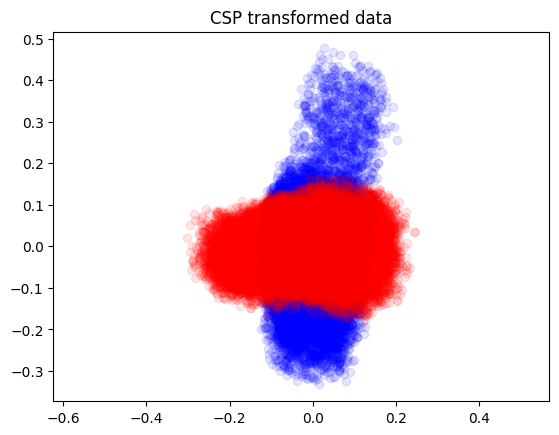

(2,)
(500, 2, 100)


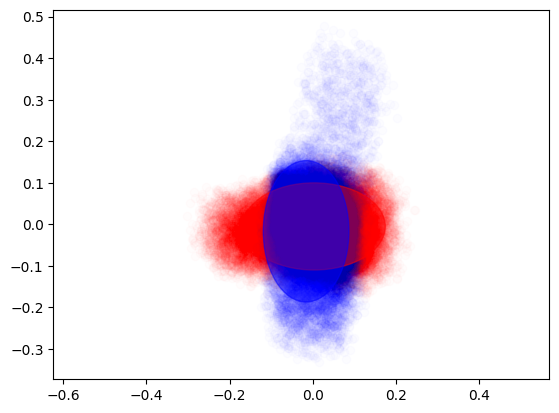

In [14]:
from scipy import linalg as la
import numpy as np
from matplotlib.patches import Ellipse



def plot_cov_ellipse(ax, cov, pos, nstd=2, **kwargs):
    # Compute eigenvalues and eigenvectors of the covariance matrix
    vals, vecs = np.linalg.eigh(cov)
    # Compute the angle of rotation
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height of the ellipse are proportional to the eigenvalues
    width, height = 2 * nstd * np.sqrt(vals)

    # Plot the ellipse
    ellipse = Ellipse(xy=pos, width=width/10, height=height/10, angle=theta, **kwargs)
    ax.add_patch(ellipse)

def draw_ellipse(X, Y):
    num_classes = len(np.unique(Y))

    covariances = []
    for i in range(num_classes):
        X_class = X[Y == i]
        S_class = np.mean([np.matmul(X_class[j], X_class[j].T) for j in range(X_class.shape[0])], axis=0)
        covariances.append(S_class)

    S0 = covariances[0]
    S1 = covariances[1]
        
    # Plot the data
    X0 = X[Y == 0]
    X1 = X[Y == 1]
    fig, ax = plt.subplots()
    ax.scatter(X0[:, 0], X0[:, 1], alpha=0.01, color='red')
    print(np.mean(X0, axis=(0,2)).shape)
    print(X0.shape)
    plot_cov_ellipse(ax, S0, pos=np.mean(X0, axis=(0,2)), nstd=2, alpha=0.5, color='red')
    plt.axis('equal')
    # plt.show()
    
    # fig, ax = plt.subplots()
    ax.scatter(X1[:, 0], X1[:, 1], alpha=0.01, color='blue')
    plot_cov_ellipse(ax, S1, pos=np.mean(X1, axis=(0,1)), nstd=2, alpha=0.5, color='blue')
    plt.axis('equal')
    plt.show()

def csp_scipy(X, Y, num_filters):

    num_classes = len(np.unique(Y))

    covariances = []
    for i in range(num_classes):
        X_class = X[Y == i]
        S_class = np.mean([np.matmul(X_class[j], X_class[j].T) for j in range(X_class.shape[0])], axis=0)
        covariances.append(S_class)

    S0 = covariances[0]
    S1 = covariances[1]

    d, V = la.eigh(S0, S0 + S1)

    # get order of eigenvalues
    idx = np.argsort(np.abs(d - 0.5))[::-1]

    # reorder the eigenvectors
    V = V[:, idx]

    # transpose
    W = V.T

    # compute the patterns
    pattern = np.linalg.pinv(V)

    #select the two most important filters
    W = W[: num_filters]

    return W
    
W = csp_scipy(X, Y, 2)


def apply_csp_filter(X, W, mean_power=False):
    X_csp = np.asarray([np.dot(W, epoch) for epoch in X])
    if mean_power:
        X_csp = (X_csp**2).mean(axis=2)
    
    return X_csp

X_csp = apply_csp_filter(X, W)





#plot before and after
plt.scatter(X[:500, :, 0], X[:500, :, 1], color='red', alpha=0.1)
plt.scatter(X[500:, :, 0], X[500:, :, 1], color='blue', alpha=0.1)
plt.title('Before CSP')
plt.axis('equal')
plt.show()

# Plot the results
print(X_csp.shape)
plt.scatter(X_csp[500:, 0], X_csp[500:, 1], color='blue', alpha=0.1)
plt.scatter(X_csp[:500, 0], X_csp[:500, 1], color='red', alpha=0.1)
plt.title('CSP transformed data')
plt.axis('equal')
plt.show()

draw_ellipse(X_csp, Y)

(1000, 2)
(1000, 2, 2)
(1000, 2)


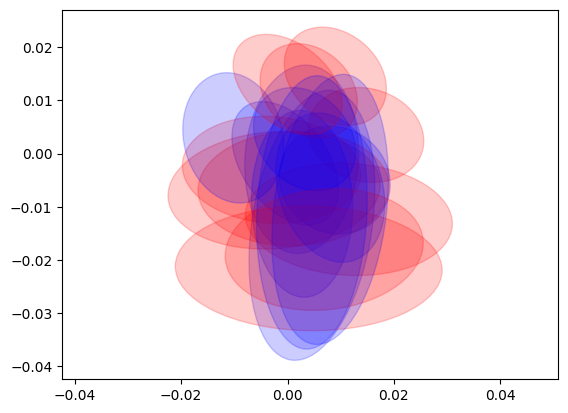

0.94


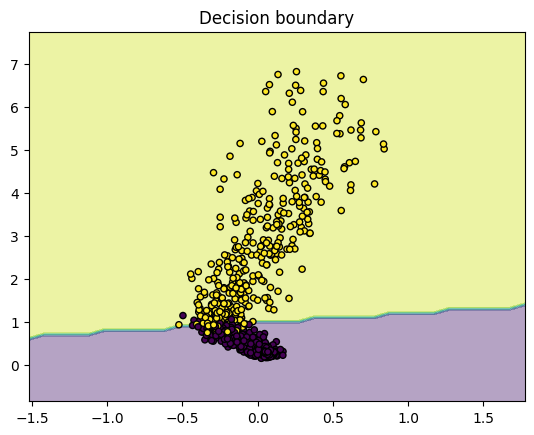

In [15]:
from sklearn.model_selection import train_test_split

mean_dataset = np.mean(X_csp, axis=(2))
cov_dataset = np.array([np.cov(trial) for trial in X_csp])

print(mean_dataset.shape)
print(cov_dataset.shape)

# dataset = np.array([[mean_dataset[i][0], mean_dataset[i][1], cov_dataset[i][0][0], cov_dataset[i][0][1], cov_dataset[i][1][1]] for i in range(X_csp.shape[0])])
# dataset = np.array([[mean_dataset[i][0], mean_dataset[i][1], cov_dataset[i][0][1]/cov_dataset[i][0][0], cov_dataset[i][1][1]/cov_dataset[i][0][0]] for i in range(X_csp.shape[0])])
dataset = np.array([[cov_dataset[i][0][1]/cov_dataset[i][0][0], cov_dataset[i][1][1]/cov_dataset[i][0][0]] for i in range(X_csp.shape[0])])

# the mean is not used because it is usually around zero for both classes. The covariance is the most important feature as it dictates the orientation of the distribution.
# Because standard dev can change while remaining the same distribution, we normalize the covariance matrix by the variance of the first dimension. This way, the covariance
# matrix is normalized, detecting horizontal or vertical distributions, independently of the scale of the data.

print(dataset.shape)
X_train, X_test, Y_train, Y_test = train_test_split(dataset, Y, test_size=0.2)


#plot example of data
fig, ax = plt.subplots()
for i in range(10):
    # ax.scatter(X_csp[i, 0], X_csp[i, 1], color='red', alpha=0.1)
    # ax.scatter(X_csp[500+i, 0], X_csp[500+i, 1], color='blue', alpha=0.1)

    plot_cov_ellipse(ax, cov_dataset[i], pos=mean_dataset[i], nstd=2, alpha=0.2, color='red')
    plot_cov_ellipse(ax, cov_dataset[500+i], pos=mean_dataset[500+i], nstd=2, alpha=0.2, color='blue')
    
ax.axis('equal')
plt.show()

# fit linear classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
print(clf.score(X_test, Y_test))


# plot decision boundary
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
ax.contourf(xx, yy, Z, alpha=0.4)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=20, edgecolor='k')
ax.set_title('Decision boundary')
plt.show()

In [1]:
import os

filenames = os.listdir('data')
print(filenames)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data'